In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('train_dataset.csv')
df.head(3)

,ID,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,7135,1654,CL,D-penicillamine,19581,F,N,N,Y,N,0.3,279.0,2.96,84.0,1500.8,99.43,109.0,293.0,10.2,4.0
1,7326,41,C,D-penicillamine,22880,F,NaN,N,NaN,N,0.3,NaN,2.96,NaN,1835.4,26.35,131.0,308.0,10.8,1.0
2,7254,297,D,NaN,27957,F,N,N,NaN,N,0.3,328.0,2.64,4.0,NaN,NaN,116.0,194.0,10.3,3.0


In [3]:
# Remove id column as it won't help in prediction
df.drop(labels='ID', axis=1, inplace = True)

#### Identifying different datatypes

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6800 entries, 0 to 6799
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   N_Days         6800 non-null   int64  
 1   Status         6800 non-null   object 
 2   Drug           4775 non-null   object 
 3   Age            6800 non-null   int64  
 4   Sex            6800 non-null   object 
 5   Ascites        4554 non-null   object 
 6   Hepatomegaly   4373 non-null   object 
 7   Spiders        4210 non-null   object 
 8   Edema          6800 non-null   object 
 9   Bilirubin      6800 non-null   float64
 10  Cholesterol    3699 non-null   float64
 11  Albumin        6800 non-null   float64
 12  Copper         4644 non-null   float64
 13  Alk_Phos       4302 non-null   float64
 14  SGOT           4698 non-null   float64
 15  Tryglicerides  3988 non-null   float64
 16  Platelets      6462 non-null   float64
 17  Prothrombin    6645 non-null   float64
 18  Stage   

In [5]:
df_num = df.select_dtypes(include='number').columns

In [6]:
df_cat = df.select_dtypes(include='object').columns

Checking in numerical column, If all columns are continuous or some are discrete. For this we will check all columns that have less than 20 unique values or looks like a discrete.

In [7]:
df[df_num].nunique()

N_Days           3069
Age              4744
Bilirubin         203
Cholesterol       456
Albumin           257
Copper            277
Alk_Phos         3607
SGOT             3129
Tryglicerides     268
Platelets         498
Prothrombin        68
Stage               4
dtype: int64

'Stage' column looks like an discrete column and also can be added into df_cat. 

In [8]:
df['Stage'].value_counts()

4.0    3506
2.0    1507
3.0    1322
1.0     465
Name: Stage, dtype: int64

#### Quantify missing values

In [9]:
df.isnull().mean()

N_Days           0.000000
Status           0.000000
Drug             0.297794
Age              0.000000
Sex              0.000000
Ascites          0.330294
Hepatomegaly     0.356912
Spiders          0.380882
Edema            0.000000
Bilirubin        0.000000
Cholesterol      0.456029
Albumin          0.000000
Copper           0.317059
Alk_Phos         0.367353
SGOT             0.309118
Tryglicerides    0.413529
Platelets        0.049706
Prothrombin      0.022794
Stage            0.000000
dtype: float64

In [10]:
df.isnull().mean()[df.isnull().mean()>0]

Drug             0.297794
Ascites          0.330294
Hepatomegaly     0.356912
Spiders          0.380882
Cholesterol      0.456029
Copper           0.317059
Alk_Phos         0.367353
SGOT             0.309118
Tryglicerides    0.413529
Platelets        0.049706
Prothrombin      0.022794
dtype: float64

In [11]:
miss_cols = df.isnull().mean()[df.isnull().mean()>0].index

In [12]:
df_miss = df[miss_cols]

miss_col_num = df_miss.select_dtypes(include='number').columns
miss_col_cat = df_miss.select_dtypes(include='object').columns

In [13]:
df[miss_col_cat].nunique()

Drug            2
Ascites         2
Hepatomegaly    2
Spiders         2
dtype: int64

In [14]:
df[miss_col_cat].isna().mean()

Drug            0.297794
Ascites         0.330294
Hepatomegaly    0.356912
Spiders         0.380882
dtype: float64

As all them almost or more than 30%, if try to impute them with mode, it will imbalance the feature. So here we can impute them with new category "missing"

In [15]:
for i in miss_col_cat:
    m = 'missing'
    df[i] = df[i].fillna(value=m)

In [16]:
df[miss_col_cat].isna().sum()

Drug            0
Ascites         0
Hepatomegaly    0
Spiders         0
dtype: int64

In [17]:
df[miss_col_num].isna().mean()

Cholesterol      0.456029
Copper           0.317059
Alk_Phos         0.367353
SGOT             0.309118
Tryglicerides    0.413529
Platelets        0.049706
Prothrombin      0.022794
dtype: float64

Here we can impute Platelets ,Prothrombin with either mean and median, for need to check distribution using box plot 

<AxesSubplot:ylabel='Prothrombin'>

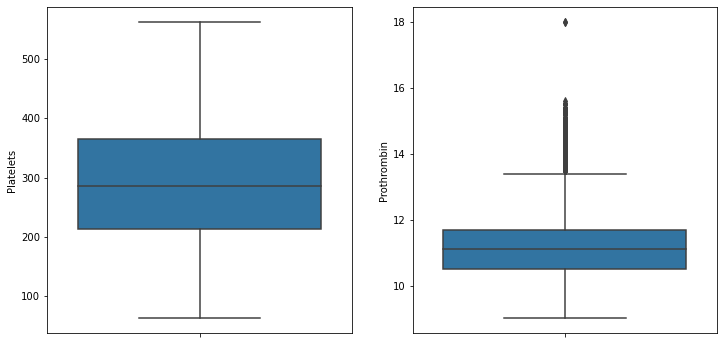

In [18]:
plt.subplots(1,2,figsize=(12,6))
plt.subplot(1,2,1)
sns.boxplot(y = df['Platelets'])
plt.subplot(1,2,2)
sns.boxplot(y = df['Prothrombin'])

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6800 entries, 0 to 6799
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   N_Days         6800 non-null   int64  
 1   Status         6800 non-null   object 
 2   Drug           6800 non-null   object 
 3   Age            6800 non-null   int64  
 4   Sex            6800 non-null   object 
 5   Ascites        6800 non-null   object 
 6   Hepatomegaly   6800 non-null   object 
 7   Spiders        6800 non-null   object 
 8   Edema          6800 non-null   object 
 9   Bilirubin      6800 non-null   float64
 10  Cholesterol    3699 non-null   float64
 11  Albumin        6800 non-null   float64
 12  Copper         4644 non-null   float64
 13  Alk_Phos       4302 non-null   float64
 14  SGOT           4698 non-null   float64
 15  Tryglicerides  3988 non-null   float64
 16  Platelets      6462 non-null   float64
 17  Prothrombin    6645 non-null   float64
 18  Stage   

As Prothrombin has outlier we need to impute it with median, but as has no outlier so we impute them with either mean or median

In [20]:
Prothrombin_med = df['Prothrombin'].median()
df['Prothrombin'] = df['Prothrombin'].fillna(value=Prothrombin_med)
Platelets_med = df['Platelets'].mean()
df['Platelets'] = df['Platelets'].fillna(value=Platelets_med)

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6800 entries, 0 to 6799
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   N_Days         6800 non-null   int64  
 1   Status         6800 non-null   object 
 2   Drug           6800 non-null   object 
 3   Age            6800 non-null   int64  
 4   Sex            6800 non-null   object 
 5   Ascites        6800 non-null   object 
 6   Hepatomegaly   6800 non-null   object 
 7   Spiders        6800 non-null   object 
 8   Edema          6800 non-null   object 
 9   Bilirubin      6800 non-null   float64
 10  Cholesterol    3699 non-null   float64
 11  Albumin        6800 non-null   float64
 12  Copper         4644 non-null   float64
 13  Alk_Phos       4302 non-null   float64
 14  SGOT           4698 non-null   float64
 15  Tryglicerides  3988 non-null   float64
 16  Platelets      6800 non-null   float64
 17  Prothrombin    6800 non-null   float64
 18  Stage   

checking if missing value has any affect on variables, and also check distribution of these variable

<AxesSubplot:ylabel='Tryglicerides'>

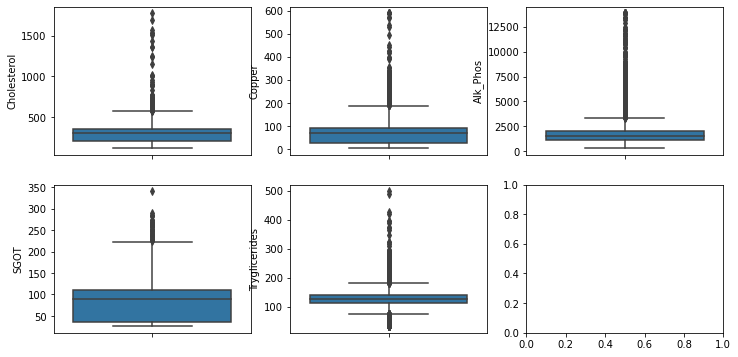

In [22]:
plt.subplots(2,3,figsize=(12,6))
plt.subplot(2,3,1)
sns.boxplot(y = df['Cholesterol'])
plt.subplot(2,3,2)
sns.boxplot(y = df['Copper'])
plt.subplot(2,3,3)
sns.boxplot(y = df['Alk_Phos'])
plt.subplot(2,3,4)
sns.boxplot(y = df['SGOT'])
plt.subplot(2,3,5)
sns.boxplot(y = df['Tryglicerides'])

<AxesSubplot:xlabel='Tryglicerides', ylabel='Count'>

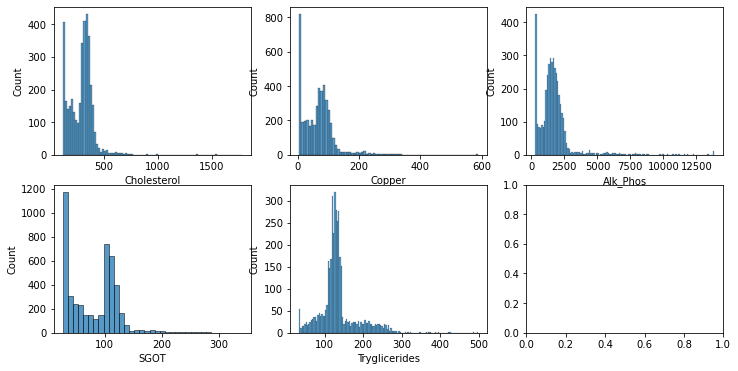

In [23]:
plt.subplots(2,3,figsize=(12,6))
plt.subplot(2,3,1)
sns.histplot(df['Cholesterol'])
plt.subplot(2,3,2)
sns.histplot(df['Copper'])
plt.subplot(2,3,3)
sns.histplot(df['Alk_Phos'])
plt.subplot(2,3,4)
sns.histplot(df['SGOT'])
plt.subplot(2,3,5)
sns.histplot(df['Tryglicerides'])

As all of the columns have outliers, we should use median to impute

here I think we can go three ways, as our missing values are all thershold 
- Imputing all the columns with median
- Imputing and adding missing value indicator
- Dropping all the columns with more than 30%

In [24]:
df_imp = df.copy()
df_imp_m = df.copy()
df_drop = df.copy()

In [25]:
cols_to_work = ['Cholesterol', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides']

Imputing values with median

In [26]:
for i in cols_to_work:
    med_val = df_imp[i].median()
    df_imp[i] = df_imp[i].fillna(value = med_val)
    col_name = i + 'miss_ind'
    df_imp_m[col_name] = np.where(df_imp_m[i].isnull,1,0)
    df_imp_m[i] = df_imp[i]

In [27]:
df_drop.drop(labels = cols_to_work ,axis = 1 ,inplace = True)

In [28]:
cols_to_encode = ['Drug','Sex','Ascites','Hepatomegaly','Spiders','Edema']
df_drop[cols_to_encode].head()

,Drug,Sex,Ascites,Hepatomegaly,Spiders,Edema
0,D-penicillamine,F,N,N,Y,N
1,D-penicillamine,F,missing,N,missing,N
2,missing,F,N,N,missing,N
3,D-penicillamine,F,missing,Y,Y,N
4,D-penicillamine,F,missing,missing,missing,N


Encoding Sex column

In [29]:
df_imp['Sex'] = df_imp['Sex'].map({'F':1,'M':0})
df_imp_m['Sex'] = df_imp_m['Sex'].map({'F':1,'M':0})
df_drop['Sex'] = df_drop['Sex'].map({'F':1,'M':0})

In [30]:
df_imp['Status'].value_counts()

C     3643
D     2619
CL     538
Name: Status, dtype: int64

Encoding Drug Column

In [31]:
df_imp = pd.get_dummies(df_imp, columns=['Drug','Hepatomegaly','Ascites','Edema','Spiders','Status'] ,drop_first=True)
df_imp_m = pd.get_dummies(df_imp_m, columns=['Drug','Hepatomegaly','Ascites','Edema','Spiders','Status'] ,drop_first=True)
df_drop = pd.get_dummies(df_drop, columns=['Drug','Hepatomegaly','Ascites','Edema','Spiders','Status'] ,drop_first=True)

In [32]:
df_imp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6800 entries, 0 to 6799
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   N_Days                6800 non-null   int64  
 1   Age                   6800 non-null   int64  
 2   Sex                   6800 non-null   int64  
 3   Bilirubin             6800 non-null   float64
 4   Cholesterol           6800 non-null   float64
 5   Albumin               6800 non-null   float64
 6   Copper                6800 non-null   float64
 7   Alk_Phos              6800 non-null   float64
 8   SGOT                  6800 non-null   float64
 9   Tryglicerides         6800 non-null   float64
 10  Platelets             6800 non-null   float64
 11  Prothrombin           6800 non-null   float64
 12  Stage                 6800 non-null   float64
 13  Drug_Placebo          6800 non-null   uint8  
 14  Drug_missing          6800 non-null   uint8  
 15  Hepatomegaly_Y       

In [33]:
df_imp_m.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6800 entries, 0 to 6799
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   N_Days                 6800 non-null   int64  
 1   Age                    6800 non-null   int64  
 2   Sex                    6800 non-null   int64  
 3   Bilirubin              6800 non-null   float64
 4   Cholesterol            6800 non-null   float64
 5   Albumin                6800 non-null   float64
 6   Copper                 6800 non-null   float64
 7   Alk_Phos               6800 non-null   float64
 8   SGOT                   6800 non-null   float64
 9   Tryglicerides          6800 non-null   float64
 10  Platelets              6800 non-null   float64
 11  Prothrombin            6800 non-null   float64
 12  Stage                  6800 non-null   float64
 13  Cholesterolmiss_ind    6800 non-null   int32  
 14  Coppermiss_ind         6800 non-null   int32  
 15  Alk_

In [34]:
df_drop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6800 entries, 0 to 6799
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   N_Days                6800 non-null   int64  
 1   Age                   6800 non-null   int64  
 2   Sex                   6800 non-null   int64  
 3   Bilirubin             6800 non-null   float64
 4   Albumin               6800 non-null   float64
 5   Platelets             6800 non-null   float64
 6   Prothrombin           6800 non-null   float64
 7   Stage                 6800 non-null   float64
 8   Drug_Placebo          6800 non-null   uint8  
 9   Drug_missing          6800 non-null   uint8  
 10  Hepatomegaly_Y        6800 non-null   uint8  
 11  Hepatomegaly_missing  6800 non-null   uint8  
 12  Ascites_Y             6800 non-null   uint8  
 13  Ascites_missing       6800 non-null   uint8  
 14  Edema_S               6800 non-null   uint8  
 15  Edema_Y              

Checking correlation of variable with one another

<AxesSubplot:>

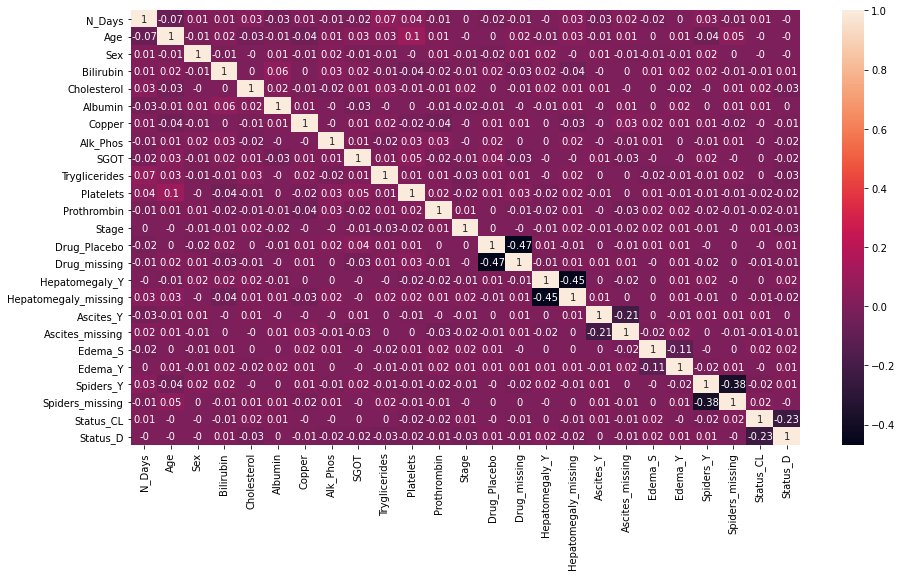

In [35]:
plt.figure(figsize=(15,8))
sns.heatmap(round(df_imp.corr(),2),annot=True)

<AxesSubplot:>

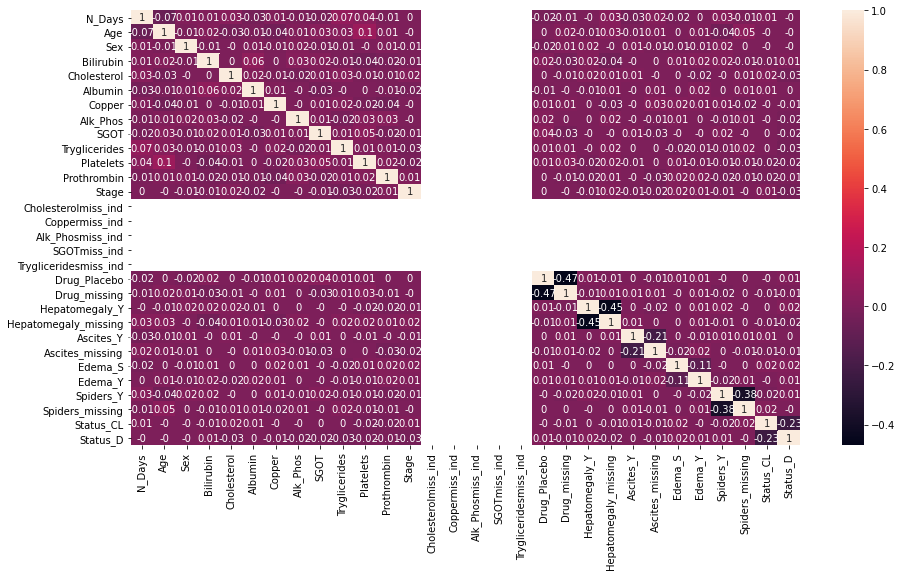

In [36]:
plt.figure(figsize=(15,8))
sns.heatmap(round(df_imp_m.corr(),2),annot=True)

<AxesSubplot:>

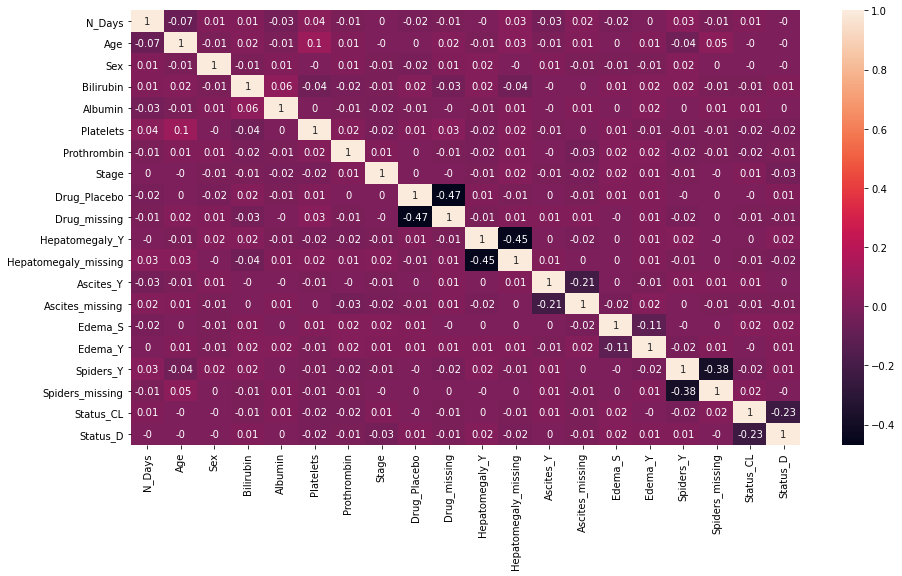

In [37]:
plt.figure(figsize=(15,8))
sns.heatmap(round(df_drop.corr(),2),annot=True)

### Working with impute+missing ind data

In [38]:
y = df_imp_m.pop('Stage')
X = df_imp_m

In [39]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

In [40]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5440 entries, 4476 to 5640
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   N_Days                 5440 non-null   int64  
 1   Age                    5440 non-null   int64  
 2   Sex                    5440 non-null   int64  
 3   Bilirubin              5440 non-null   float64
 4   Cholesterol            5440 non-null   float64
 5   Albumin                5440 non-null   float64
 6   Copper                 5440 non-null   float64
 7   Alk_Phos               5440 non-null   float64
 8   SGOT                   5440 non-null   float64
 9   Tryglicerides          5440 non-null   float64
 10  Platelets              5440 non-null   float64
 11  Prothrombin            5440 non-null   float64
 12  Cholesterolmiss_ind    5440 non-null   int32  
 13  Coppermiss_ind         5440 non-null   int32  
 14  Alk_Phosmiss_ind       5440 non-null   int32  
 15  S

In [57]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

In [66]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

rfe = RFE(rfc, 10)             # running RFE
rfe = rfe.fit(X_train, y_train)

In [67]:
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('N_Days', True, 1),
 ('Age', True, 1),
 ('Sex', False, 12),
 ('Bilirubin', False, 2),
 ('Cholesterol', True, 1),
 ('Albumin', True, 1),
 ('Copper', True, 1),
 ('Alk_Phos', True, 1),
 ('SGOT', True, 1),
 ('Tryglicerides', True, 1),
 ('Platelets', True, 1),
 ('Prothrombin', True, 1),
 ('Cholesterolmiss_ind', False, 17),
 ('Coppermiss_ind', False, 19),
 ('Alk_Phosmiss_ind', False, 20),
 ('SGOTmiss_ind', False, 18),
 ('Trygliceridesmiss_ind', False, 16),
 ('Drug_Placebo', False, 8),
 ('Drug_missing', False, 7),
 ('Hepatomegaly_Y', False, 9),
 ('Hepatomegaly_missing', False, 5),
 ('Ascites_Y', False, 13),
 ('Ascites_missing', False, 4),
 ('Edema_S', False, 11),
 ('Edema_Y', False, 15),
 ('Spiders_Y', False, 10),
 ('Spiders_missing', False, 3),
 ('Status_CL', False, 14),
 ('Status_D', False, 6)]

In [73]:
col = X_train.columns[rfe.support_]
X_train_new = X_train[col]

Creating models using rfe.support columns

In [74]:
rfc1 = RandomForestClassifier()
rfc1.fit(X_train_new,y_train)


RandomForestClassifier()

In [83]:
# Calculate the VIFs for the new model
def cal_VIF(X):
    from statsmodels.stats.outliers_influence import variance_inflation_factor

    vif = pd.DataFrame()
    X = X_train_new
    vif['Features'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    return vif

In [77]:
cal_VIF(X_train_new)

,Features,VIF
9,Prothrombin,49.85
3,Albumin,28.45
1,Age,22.43
7,Tryglicerides,13.33
2,Cholesterol,10.93
8,Platelets,7.84
6,SGOT,5.93
4,Copper,2.82
5,Alk_Phos,2.81
0,N_Days,2.59


In [80]:
X_train_new.pop('Prothrombin')

In [81]:
rfc1.fit(X_train_new,y_train)

RandomForestClassifier()

In [84]:
cal_VIF(X_train_new)

,Features,VIF
3,Albumin,22.21
1,Age,19.38
7,Tryglicerides,12.49
2,Cholesterol,10.26
8,Platelets,7.65
6,SGOT,5.81
4,Copper,2.80
5,Alk_Phos,2.76
0,N_Days,2.56


In [85]:
X_train_new.pop('Albumin')
rfc1.fit(X_train_new,y_train)
cal_VIF(X_train_new)

,Features,VIF
1,Age,16.20
6,Tryglicerides,11.65
2,Cholesterol,9.44
7,Platelets,7.46
5,SGOT,5.73
3,Copper,2.75
4,Alk_Phos,2.73
0,N_Days,2.55


In [86]:
X_train_new.pop('Age')
rfc1.fit(X_train_new,y_train)
cal_VIF(X_train_new)

,Features,VIF
5,Tryglicerides,9.89
1,Cholesterol,8.47
6,Platelets,6.67
4,SGOT,5.45
2,Copper,2.72
3,Alk_Phos,2.69
0,N_Days,2.55


In [87]:
X_train_new.pop('Tryglicerides')
rfc1.fit(X_train_new,y_train)
cal_VIF(X_train_new)

,Features,VIF
1,Cholesterol,7.03
5,Platelets,6.10
4,SGOT,5.15
3,Alk_Phos,2.66
2,Copper,2.65
0,N_Days,2.48


In [88]:
X_train_new.pop('Cholesterol')
rfc1.fit(X_train_new,y_train)
cal_VIF(X_train_new)

,Features,VIF
4,Platelets,5.19
3,SGOT,4.50
2,Alk_Phos,2.58
1,Copper,2.53
0,N_Days,2.37


In [89]:
X_train_new.pop('Platelets')
rfc1.fit(X_train_new,y_train)
cal_VIF(X_train_new)

,Features,VIF
3,SGOT,3.40
1,Copper,2.40
2,Alk_Phos,2.38
0,N_Days,2.19


In [90]:
rfc1.fit(X_train_new,y_train)

RandomForestClassifier()

In [93]:
y_tr_pred1 = rfc1.predict(X_train_new)
y_tst_pred1 = rfc1.predict(X_test[X_train_new.columns])

In [94]:
from sklearn.metrics import confusion_matrix, classification_report

print(confusion_matrix(y_train ,y_tr_pred1))
print(classification_report(y_train ,y_tr_pred1))

[[ 362    4    0    2]
 [   0 1203    1    7]
 [   1    2 1056   15]
 [   0    3    4 2780]]
              precision    recall  f1-score   support

         1.0       1.00      0.98      0.99       368
         2.0       0.99      0.99      0.99      1211
         3.0       1.00      0.98      0.99      1074
         4.0       0.99      1.00      0.99      2787

    accuracy                           0.99      5440
   macro avg       0.99      0.99      0.99      5440
weighted avg       0.99      0.99      0.99      5440



In [95]:
print(confusion_matrix(y_test ,y_tst_pred1))
print(classification_report(y_test ,y_tst_pred1))

[[  2  11   8  76]
 [  6  38  29 223]
 [  7  36  13 192]
 [  8 106  70 535]]
              precision    recall  f1-score   support

         1.0       0.09      0.02      0.03        97
         2.0       0.20      0.13      0.16       296
         3.0       0.11      0.05      0.07       248
         4.0       0.52      0.74      0.61       719

    accuracy                           0.43      1360
   macro avg       0.23      0.24      0.22      1360
weighted avg       0.34      0.43      0.37      1360



Issue is most of the data points are pointing towards 4, it is because our dataset is imbalanced towards 4. so we need to make it balanced

In [96]:
y.value_counts(normalize=True)

4.0    0.515588
2.0    0.221618
3.0    0.194412
1.0    0.068382
Name: Stage, dtype: float64

Need to take samples of data that is balanced will work on that